In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
import numpy as np
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('D:/Study_material/Data_Science/capstone_project/ML_practise/data/quora.csv')
df = df.dropna(how="any").reset_index(drop=True)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<AxesSubplot:xlabel='is_duplicate'>

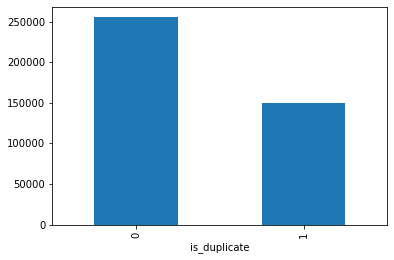

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [7]:
a = 0 
for i in range(a,a+10):
    print(df.question1[i])
    print(df.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

In [8]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

In [9]:
def clean(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

#    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    # we have cases like "Sam is" or "Sam's" (i.e. his) 
    # these two cases aren't separable, so, choose to compromise are kill 
    #"'s" directly
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # removing comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
#   # all numbers should separate from words, this is too aggressive
    
#     def pad_number(pattern):
#         matched_string = pattern.group(0)
#         return pad_str(matched_string)
#     text = re.sub('[0-9]+', pad_number, text)
    
    # adding padding to punctuations and special chars, 
    # we still need them later
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
#    def pad_pattern(pattern):
#        matched_string = pattern.group(0)
#       return pad_str(matched_string)
#    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # indian rupees
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replacing the float numbers with a random number, 
    # it will be parsed as number afterward, and also been 
    # replaced with word "number"
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # Removing punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       
    return text

In [10]:
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

In [11]:
a = 0 
for i in range(a,a+10):
    print(df.question1[i])
    print(df.question2[i])
    print()

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market

what is the story of kohinoor kohinoor diamond
what would happen if the indian government stole the kohinoor kohinoor diamond back

how can i increase the speed of my internet connection while using a vpn
how can internet speed be increased by hacking through dns

why am i mentally very lonely how can i solve it
find the remainder when math2324math is divided by 2423

which one dissolve in water quikly sugar salt methane and carbon di oxide
which fish would survive in salt water

astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
i am a triple capricorn sun moon and ascendant in capricorn what does this say about me

should i buy tiago
what keeps childern active and far from phone and video games

how can i be a good geologist
what should i do to be a great geologist

when do you use  nonasciiword  instead of  nonasciiword 
when do y

# BOW + Xgboost Model

In [12]:
cnt_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
cnt_vect.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = cnt_vect.transform(df['question1'].values)
trainq2_trans = cnt_vect.transform(df['question2'].values)

labels = df['is_duplicate'].values

X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels

X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 

xgb_prediction = xgb_model.predict(X_valid)

[13:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



In [13]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))

print('validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))

print(classification_report(y_valid, xgb_prediction))

training score: 0.8282338975315802
validation score: 0.7608343800549517
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     84355
           1       0.78      0.60      0.68     49080

    accuracy                           0.79    133435
   macro avg       0.79      0.75      0.76    133435
weighted avg       0.79      0.79      0.78    133435



# Word level TF-IDF

In [14]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

tfidf_vect.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = tfidf_vect.transform(df['question1'].values)
trainq2_trans = tfidf_vect.transform(df['question2'].values)

labels = df['is_duplicate'].values

X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels

X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [15]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 

xgb_prediction = xgb_model.predict(X_valid)

print('word level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))

print('word level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))

print(classification_report(y_valid, xgb_prediction))

[13:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

word level tf-idf training score: 0.8921487996600306
word level tf-idf validation score: 0.7627232790678351
              precision    recall  f1-score   support

           0       0.80      0.90      0.84     84355
           1       0.77      0.61      0.68     49080

    accuracy                           0.79    133435
   macro avg       0.79      0.75      0.76    133435
weighted avg       0.79      0.79      0.78    133435



# N-gram Level TF-IDF

In [16]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)

tfidf_vect_ngram.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = tfidf_vect_ngram.transform(df['question1'].values)
trainq2_trans = tfidf_vect_ngram.transform(df['question2'].values)

labels = df['is_duplicate'].values

X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels

X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [17]:
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 

xgb_prediction = xgb_model.predict(X_valid)

print('n-gram level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))

print('n-gram level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))

print(classification_report(y_valid, xgb_prediction))

[13:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

n-gram level tf-idf training score: 0.7421493527998253
n-gram level tf-idf validation score: 0.6783981743935557
              precision    recall  f1-score   support

           0       0.73      0.91      0.81     84355
           1       0.74      0.43      0.54     49080

    accuracy                           0.74    133435
   macro avg       0.74      0.67      0.68    133435
weighted avg       0.74      0.74      0.71    133435



# Character Level TF-IDF 

In [18]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)

tfidf_vect_ngram_chars.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = tfidf_vect_ngram_chars.transform(df['question1'].values)
trainq2_trans = tfidf_vect_ngram_chars.transform(df['question2'].values)

labels = df['is_duplicate'].values

X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels

X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 

xgb_prediction = xgb_model.predict(X_valid)

print('character level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))

print('character level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))

print(classification_report(y_valid, xgb_prediction))

C:\Users\Shivani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:506: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


[13:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



KeyboardInterrupt: 